In [ ]:
!pip install tensorflow-addons
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### 배치 사이즈 조절은 utils/Generator.py 에서 Batch_size를 조절하면 됩니다.

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import cifar100

# 현재 디렉토리의 utils 폴더 안에 위치시켜주세요.
from utils.Generator import DataGenerator
from utils.Network import Build_Network
from utils.SAM import train_step_sam

booster=True
n_classes = 100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)

train_data_generator = DataGenerator(x_train, y_train, augment=True)
valid_data_generator = DataGenerator(x_test, y_test, augment=False)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

network = Build_Network(n_classes,booster=booster)

if booster==True:
    network.load_weights('./transfer_learning.h5')
    model = keras.Sequential()
    model.add(network)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_classes, activation='softmax'))
else:
    model = network

class MyModel(keras.Model): #SAM Optimizer를 적용하는 부분
    def __init__(self,num_classes=n_classes):
        super(MyModel, self).__init__(name='model')
        self.base=model
    def call(self, x):
        x = self.base(x)
        return x
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05)

model.summary()
model = MyModel(model)
model.build((None, 112, 112, 3))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop], verbose = 1, epochs = 25)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 1280)        4049564   
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


<ipython-input-1-4e5351a57068>:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop], verbose = 1, epochs = 25)


Epoch 1/25
390/390 [==============================] - 338s 701ms/step - loss: 3.4735 - accuracy: 0.2088 - val_loss: 1.5905 - val_accuracy: 0.5754 - lr: 1.0000e-04
Epoch 2/25
390/390 [==============================] - 271s 693ms/step - loss: 1.9250 - accuracy: 0.4847 - val_loss: 1.0737 - val_accuracy: 0.6881 - lr: 1.0000e-04
Epoch 3/25
390/390 [==============================] - 274s 701ms/step - loss: 1.5664 - accuracy: 0.5636 - val_loss: 0.9204 - val_accuracy: 0.7232 - lr: 1.0000e-04
Epoch 4/25
390/390 [==============================] - 274s 702ms/step - loss: 1.3799 - accuracy: 0.6081 - val_loss: 0.8324 - val_accuracy: 0.7438 - lr: 1.0000e-04
Epoch 5/25
390/390 [==============================] - 272s 695ms/step - loss: 1.2517 - accuracy: 0.6410 - val_loss: 0.7806 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 6/25
390/390 [==============================] - 273s 699ms/step - loss: 1.1697 - accuracy: 0.6622 - val_loss: 0.7413 - val_accuracy: 0.7736 - lr: 1.0000e-04
Epoch 7/25
390/390 [==

In [ ]:
model.save_weights("cifar_efficientnetb0_weights.h5")

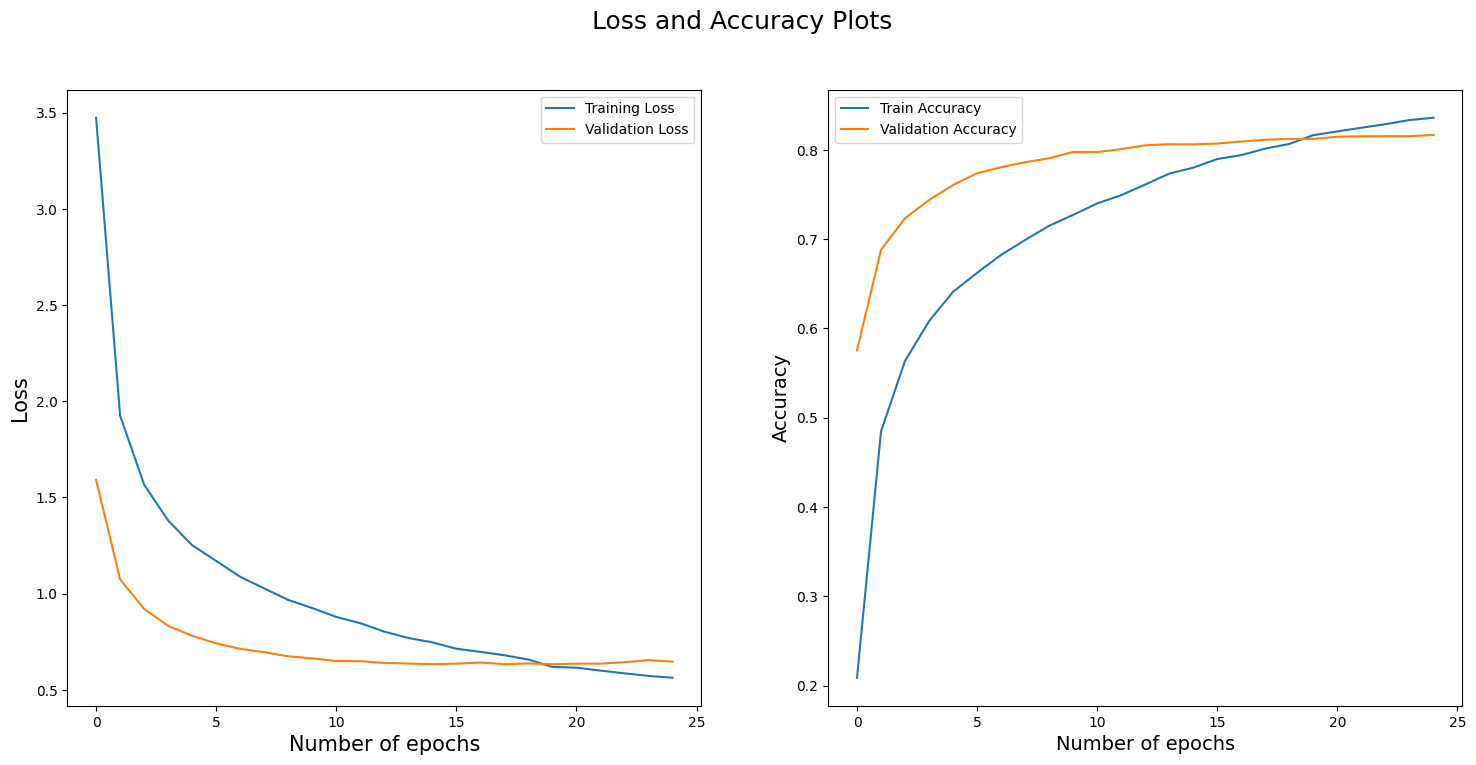

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_data_generator, verbose = 1)
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

<ipython-input-3-f6ffc86a03ce>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_data_generator, verbose = 1)


78/78 [==============================] - 6s 76ms/step - loss: 0.6480 - accuracy: 0.8162
Validation Accuracy:  81.62 %


In [ ]:
import pickle
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

In [ ]:
history = pickle.load(open('./trainHistoryDict', "rb"))